In [1]:
import pandas
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.scenario import Scenario
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve

In [2]:
demand_factor = pandas.DataFrame(data={'Power': [0.6, 0.7, 0.8, 0.3]})
capacity_factor_pv = pandas.DataFrame(data={'PV': [0.6, 0.8, 0.9, 0.7]})
capacity_factor_wf = pandas.DataFrame(data={'WF': [0.9, 0.8, 0.5, 0.7]})

In [3]:
scales = TemporalScale(discretization_list=[1, 4])

In [4]:
Solar = Resource(name='Solar', cons_max=100, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max=100, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW', demand=True,
                 label='Power generated', varying=[VaryingResource.DETERMINISTIC_PRICE])

In [5]:
LiI = Process(name='LiI', storage=Power, capex=1302182, fopex=41432, vopex=2000,
              prod_max=100, prod_min=10, store_max=100, label='Lithium-ion battery', basis='MW')

WF = Process(name='WF', conversion={Wind: -1, Power: 1}, capex=990637, fopex=3354, vopex=4953,
             prod_max=100, prod_min=10, label='Wind mill array', varying=[VaryingProcess.DETERMINISTIC_CAPACITY], basis='MW')

PV = Process(name='PV', conversion={Solar: -1, Power: 1}, capex=567000, fopex=872046, vopex=90000,
             prod_max=100, prod_min=10,  varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Solar PV', basis='MW')

In [6]:
place = Location(name='place', processes={LiI, PV, WF}, demand_factor={Power: demand_factor}, capacity_factor={PV: capacity_factor_pv, WF: capacity_factor_wf},
                 capacity_scale_level=1, demand_scale_level=1, scales=scales, label='some place')

In [7]:
case = Scenario(name='case', network=place, demand_scale_level=1, network_scale_level=0,
                scheduling_scale_level=1, scales=scales,  demand={place: {Power: 180}}, label='small scenario')

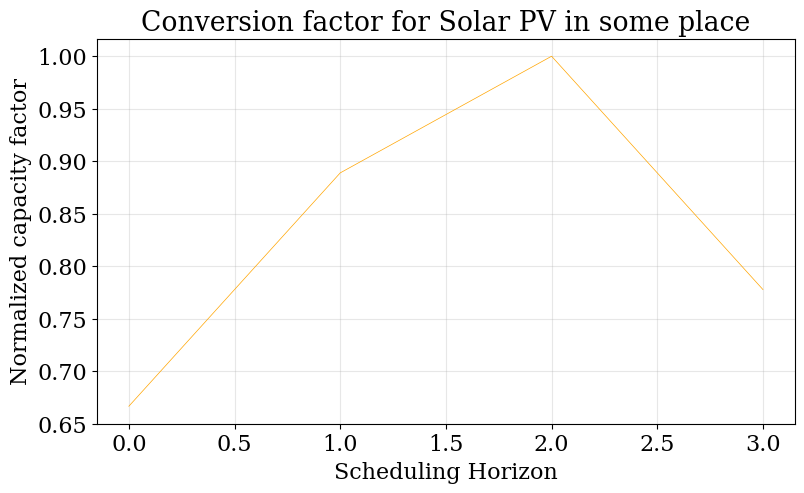

In [8]:
plot_scenario.capacity_factor(
    scenario=case, location=place, process=PV, fig_size=(9, 5), color='orange')

In [9]:
lp = formulate(scenario=case, constraints={Constraints.COST, Constraints.INVENTORY,
                 Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE}, objective=Objective.COST)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint location vopex
constraint location incidental
constraint network capex
constraint network fopex
constraint network vopex
constraint network incidental
constraint nameplate inventory
constraint storage max
constraint storage min
constraint production mode
constraint nameplate production
constraint production max
constraint production min
constraint inventory balance
constraint resource consumption
constraint resource purchase
constraint location production
constraint location discharge
constraint location consumption
constraint location purchase
constraint network production
constraint network discharge
constraint network consumption
constraint network purchase
constraint demand
objective cost


In [10]:
results = solve(scenario=case, instance=lp, solver='gurobi', name='LP')


Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 124 rows, 110 columns and 270 nonzeros
Model fingerprint: 0xe030d8bd
Coefficient statistics:
  Matrix range     [6e-01, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 105 rows and 89 columns
Presolve time: 0.02s
Presolved: 19 rows, 21 columns, 51 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2698290e+08   5.875900e+01   0.000000e+00      0s
      14    2.7746670e+08   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.04 seconds (0.00 work units)
Optimal objective  2.774667013e+08


In [11]:
results.model_summary()


SUMMARY:
            number of constraints: 124
            number of variables: 110
            number of binary variables: 0
            number of integer variables: 0
            number of continuous variables: 110
